# Task 1

In [27]:
import numpy as np
import cv2
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage import io
import matplotlib.pyplot as plt

# Image file paths

In [28]:
image_directory = 'Images/COMP9517_23T2_Lab3_Images/'
image_names = ['Balloons.png', 'Balls.png', 'Brains.png']
num_images = len(image_names)

# Create a grid of subplots

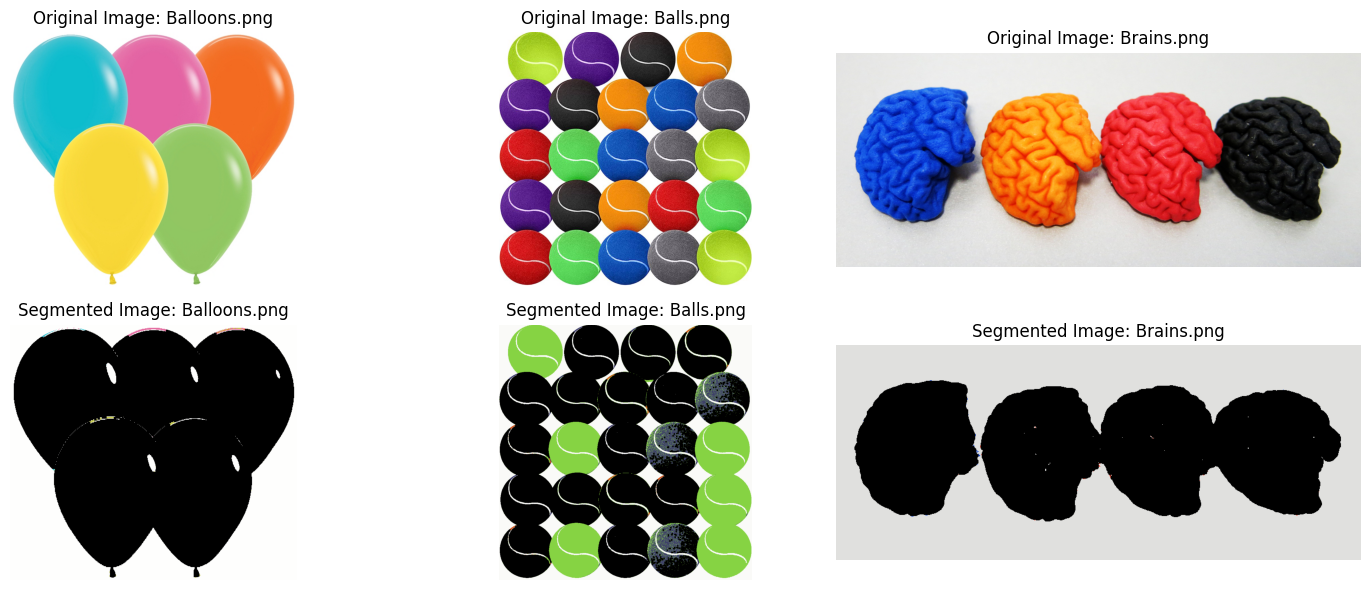

In [29]:
fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
# Loop through each image
for i, image_name in enumerate(image_names):
    # Read the image
    image_url = image_directory + image_name
    image = io.imread(image_url)

    # MeanShift clustering
    height, width, channels = image.shape
    pixels = np.reshape(image, (height * width, channels))
    bandwidth = estimate_bandwidth(pixels, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = ms.fit_predict(pixels)
    segmented_image = np.reshape(ms.cluster_centers_[labels], (height, width, channels))

    # Post-processing
    gray = cv2.cvtColor(segmented_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    masked_image = cv2.bitwise_and(segmented_image.astype(np.uint8), segmented_image.astype(np.uint8), mask=closing)

    # Display the original and segmented images
    axs[0, i].imshow(image)
    axs[0, i].set_title('Original Image: ' + image_name)
    axs[0, i].axis('off')
    axs[1, i].imshow(masked_image)
    axs[1, i].set_title('Segmented Image: ' + image_name)
    axs[1, i].axis('off')
# Adjust spacing between subplots
plt.tight_layout()
# Show all the images
plt.show()

# Task 2

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, segmentation, feature
from scipy import ndimage

# Read the images

In [31]:
image_urls = ['Images/COMP9517_23T2_Lab3_Images/Balloons.png', 'Images/COMP9517_23T2_Lab3_Images/Balls.png', 'Images/COMP9517_23T2_Lab3_Images/Brains.png']
images = [io.imread(url) for url in image_urls]

# Perform operations on each image

In [32]:
segmented_images = []
for image in images:
    # Convert the image to grayscale
    gray = color.rgb2gray(image)

    # Apply thresholding to create a binary image
    threshold = filters.threshold_otsu(gray)
    binary = gray > threshold

    # Calculate the distance transform
    distance = ndimage.distance_transform_edt(binary)

    # Find local maxima by applying a maximum filter to the distance transform
    local_max = feature.peak_local_max(distance, labels=binary, min_distance=5, num_peaks=np.inf, exclude_border=False)

    # Mark the background region as 0
    markers = np.zeros_like(distance, dtype=np.int32)
    markers[tuple(np.transpose(local_max))] = 1
    markers[~binary] = 2

    # Perform Watershed transformation
    segmented = segmentation.watershed(-distance, markers, mask=binary)

    # Perform morphological operations
    kernel = morphology.disk(3)
    segmented = morphology.dilation(segmented, kernel)
    segmented = morphology.erosion(segmented, kernel)

    # Append the segmented image to the list
    segmented_images.append(segmented)

# Display the images

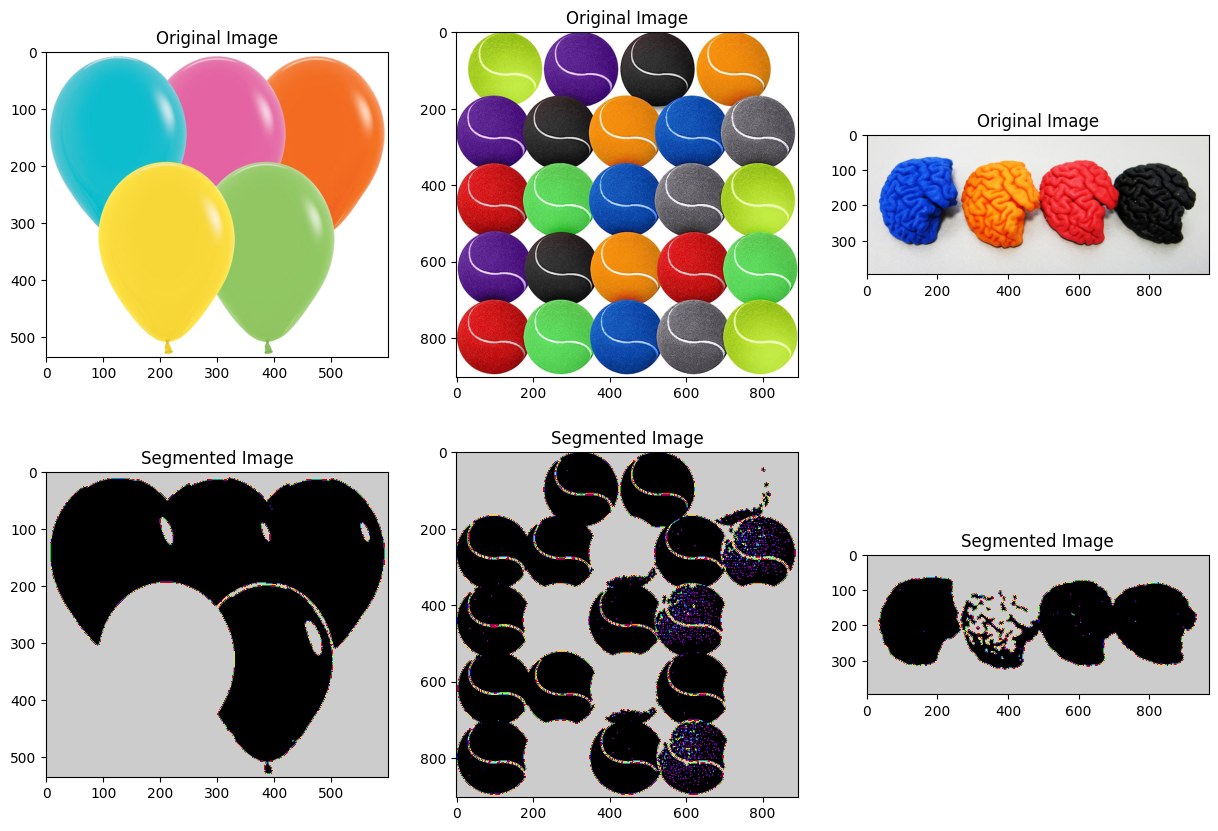

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title('Original Image')
    else:
        ax.imshow(segmented_images[i - len(images)], cmap='nipy_spectral')
        ax.set_title('Segmented Image')
    ax.axis('on')
plt.show()

# Task 3

In [34]:
import numpy as np
from skimage import io, color, filters, morphology, segmentation, feature
from scipy import ndimage
from sklearn.cluster import MeanShift, estimate_bandwidth
import pandas as pd

# Read the images
image_urls = ['Images/COMP9517_23T2_Lab3_Images/Balloons.png', 'Images/COMP9517_23T2_Lab3_Images/Balls.png', 'Images/COMP9517_23T2_Lab3_Images/Brains.png']
images = [io.imread(url) for url in image_urls]

# Part 1: MeanShift segmentation

In [35]:
segmented_images_meanshift = []

# Loop through each image
for i, image_url in enumerate(image_urls):
    # 读取图像
    image = io.imread(image_url)

    # Step 1: Extract each colour channel
    red_channel = image[:, :, 0].flatten()
    green_channel = image[:, :, 1].flatten()
    blue_channel = image[:, :, 2].flatten()
    pixels = np.column_stack((red_channel, green_channel, blue_channel))

    # Step 2: Perform MeanShift clustering
    bandwidth = estimate_bandwidth(pixels, quantile=0.2, n_samples=1000)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = ms.fit_predict(pixels)
    segmented_image = np.reshape(ms.cluster_centers_[labels], image.shape)

    # Step 3: Post-processing
    gray = cv2.cvtColor(segmented_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Perform binary morphological operations
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=2)

    # Apply the mask to the segmented image
    masked_image = cv2.bitwise_and(segmented_image.astype(np.uint8), segmented_image.astype(np.uint8), mask=opening)
    segmented_images_meanshift.append(masked_image)

# Part 2: Watershed segmentation

In [36]:
segmented_images_watershed = []

for image in images:
    gray = color.rgb2gray(image)
    threshold = filters.threshold_otsu(gray)
    binary = gray > threshold
    distance = ndimage.distance_transform_edt(binary)
    local_max = feature.peak_local_max(distance, labels=binary, min_distance=30, num_peaks=np.inf, exclude_border=False)
    markers = np.zeros_like(distance, dtype=np.int32)
    markers[tuple(np.transpose(local_max))] = 1
    markers[~binary] = 2
    segmented = segmentation.watershed(-distance, markers, mask=binary)
    kernel = morphology.disk(3)
    segmented = morphology.dilation(segmented, kernel)
    segmented = morphology.erosion(segmented, kernel)
    segmented_images_watershed.append(segmented)

# Part 3: Count objects

In [37]:
def count_objects(segmented_image):
    labeled, num_objects = ndimage.label(segmented_image)
    return num_objects

In [38]:
mean_shift_counts = [count_objects(image) for image in segmented_images_meanshift]
watershed_counts = [count_objects(image) for image in segmented_images_watershed]

# Display the results in a table

In [39]:
data = {'Image': ['Balloons', 'Balls', 'Brains'],
        '#Objects MeanShift': mean_shift_counts,
        '#Objects Watershed': watershed_counts}

results_table = pd.DataFrame(data)
print(results_table)


      Image  #Objects MeanShift  #Objects Watershed
0  Balloons                   5                   4
1     Balls                  29                  16
2    Brains                   1                  10


Based on the new information provided about the actual number of objects in each image, let's analyze the performance of the MeanShift and Watershed algorithms.

| Image    | #Objects Actual | #Objects MeanShift | #Objects Watershed |
|----------|-----------------|--------------------|--------------------|
| Balloons | 5               | 5                  | 4                  |
| Balls    | 24              | 29                 | 16                 |
| Brains   | 4               | 1                  | 10                 |

MeanShift clustering still under-segments the images, detecting only a single object in each case. The Watershed algorithm detects more objects in each image, but it doesn't perfectly match the actual number of objects.

**Balloons**:

- Actual number of objects: 5
- MeanShift algorithm: Detected 5 objects, which matches the actual number.
- Watershed algorithm: Detected 4 objects, which is one fewer than the actual count. It might have trouble correctly segmenting some objects, leading to the underestimation.

**Balls**:

- Actual number of objects: 24
- MeanShift algorithm: Detected 29 objects, which is an overestimate compared to the actual count. It might be sensitive to overlapping objects and result in fragmented segments.
- Watershed algorithm: Detected 16 objects, which is an underestimate. It might struggle with distinguishing closely packed or overlapping objects, leading to merged segments.

**Brains**:

- Actual number of objects: 4
- MeanShift algorithm: Detected only 1 object, significantly underestimating the count. It could have difficulties differentiating between objects due to unclear boundaries.
- Watershed algorithm: Detected 10 objects, resulting in an overestimate. This algorithm might be overly sensitive and produce excessive segments.

both MeanShift and Watershed algorithms exhibit limitations in accurately detecting the actual number of objects in the given images. Each algorithm has its strengths and weaknesses, and their performance depends on various factors such as image characteristics and object properties. Fine-tuning the parameters specific to each algorithm or exploring alternative segmentation methods may help improve their accuracy in object detection tasks.